In [1]:
%%capture
%cd '../../src'

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

sns.set_palette('icefire')
sns.set_style('darkgrid', {'grid.linestyle': '--', 'grid.alpha': 0.4, 'axes.formatter.limits': (-8, 9)})

from sklearn.metrics import f1_score

In [ ]:
paths = [f for f in os.listdir('../models/hslstm/') if '.DS_Store' not in f]
len(paths)

In [ ]:
def get_train_setup_params(path):
    [in_freq, lookahead, pct_thresh, _] = path.split('-')
    in_freq = int(in_freq.replace('in_freq', '')[:-1])
    lookahead = int(lookahead.replace('lookahead', ''))
    pct_thresh = int(pct_thresh.replace('pct_thresh', ''))
    return in_freq, lookahead, pct_thresh

In [ ]:
def get_score(path):
    cols = ['ticker', 'start', 'end', 'target', 'prob_0', 'prob_1', 'prob_2', 'prob_3', 'pred_label']
    try:
        with open(f'../models/hslstm/{path}/eval_results3.pkl', 'rb') as f:
            d = pickle.load(f)
            d = pd.DataFrame(d, columns = cols)
            score = f1_score(y_true = d['target'], y_pred = d['pred_label'], average = 'weighted')
            ind_scores = {}
            for lbl in sorted(d['target'].unique()):
                sub = d[d['target'] == lbl]
                ind_scores[lbl] = sum(sub['pred_label'] == lbl) / len(sub)
                #ind_scores[lbl] = f1_score(y_true = sub['target'], y_pred = sub['pred_label'], average = 'weighted')
            dict_target_counts = dict(d['target'].value_counts() / len(d) * 100)
            return score, dict_target_counts, ind_scores
    except:
        return None

In [ ]:
data = []
tgt_dist = []
for path in paths:
    in_freq, lookahead, pct_thresh = get_train_setup_params(path)
    output = get_score(path)
    if output:
        score, dict_n_tgt, ind_scores = output
        data.append((in_freq, lookahead, pct_thresh, score, ind_scores[0], ind_scores[1], ind_scores[2], ind_scores.get(3, 0)))
        for k, v in dict_n_tgt.items():
            tgt_dist.append((in_freq, lookahead, pct_thresh, k, v))

d = pd.DataFrame(data, columns = ['in_freq', 'lookahead', 'pct_thresh', 'f1_score', 'score_0', 'score_1', 'score_2', 'score_3'])
tgt_df = pd.DataFrame(tgt_dist, columns = ['in_freq', 'lookahead', 'pct_thresh', 'label', 'pct_samples'])
tgt_df['label'] = tgt_df['label'].map({0 : 'neither', 1: 'long', 2: 'short', 3: 'either'})
tgt_df.head()

In [ ]:
# threshs = sorted(d['pct_thresh'].unique())
# for lookahead in [2, 3, 4, 5]:
#     fig, axes = plt.subplots(1, 3, figsize = (16, 4))
#     for idx, ax in enumerate(axes.flatten()):
#         sns.barplot(data = tgt_df[(tgt_df['pct_thresh'] == threshs[idx]) & (tgt_df['lookahead'] == lookahead)], 
#                     x = 'label', y = 'pct_samples', hue = 'in_freq', 
#                     order = ['neither', 'long', 'short', 'either'], ax = ax)
#         ax.set_title(f'Pct thresh: {threshs[idx]}%; lookahead {lookahead} time units')
#         if idx != 0:
#             ax.legend().remove()
#     plt.tight_layout()
#     plt.show()

In [ ]:
threshs = sorted(d['pct_thresh'].unique())
fig, axes = plt.subplots(2, 2, figsize = (8, 6), sharey = True, sharex = True)
for idx, ax in enumerate(axes.flatten()):
    if idx < len(threshs):
        sns.lineplot(data = d[(d['pct_thresh'] == threshs[idx]) & (d['lookahead'].isin([2, 4, 6, 8, 10]))], 
                    x = 'in_freq', y = 'f1_score', hue = 'lookahead', ax = ax, 
                    palette = 'Set1', marker = 'o')
        ax.set_title(f'Pct thresh: {threshs[idx]}%')
        if idx != 0:
            ax.legend().remove()
    else:
        ax.remove()
plt.tight_layout()
plt.show()

In [ ]:
d.rename(columns = {'score_0' : 'accuracy_neither',
                    'score_1' : 'accuracy_long',
                    'score_2' : 'accuracy_short',
                    'score_3' : 'accuracy_either'},
         inplace = True)
print('With individual label scores')
p = d[d['in_freq'] == 30].sort_values(by = ['in_freq', 'lookahead', 'pct_thresh'])
p[p['pct_thresh'] == 1].style.background_gradient(subset = [f for f in d.columns if 'accuracy' in f], axis = 1, cmap = 'pink_r')

In [ ]:
tgt_60 = tgt_df[tgt_df['in_freq'] == 15].pivot(columns = 'label', index = ['in_freq', 'lookahead', 'pct_thresh'], values = 'pct_samples').reset_index()
tgt_60.reset_index(drop = True, inplace = True)
tgt_60 = tgt_60.round(3).sort_values(by = ['in_freq', 'lookahead', 'pct_thresh'])
print('Label distribution:')
tgt_60 = tgt_60[['in_freq', 'lookahead', 'pct_thresh', 'neither', 'long', 'short', 'either']]
tgt_60[(tgt_60['pct_thresh'] == 3)]\
    .style.background_gradient(subset = tgt_60.columns[3:], axis = 1, cmap = 'flare')

In [ ]:
threshs = sorted(d['pct_thresh'].unique())
fig, axes = plt.subplots(2, 2, figsize = (8, 6), sharey = True)
for idx, ax in enumerate(axes.flatten()):
    if idx < len(threshs):
        sns.barplot(data = tgt_df[(tgt_df['pct_thresh'] == threshs[idx]) \
                            & (tgt_df['lookahead'].isin([2, 4, 6, 8, 10])) \
                            & (tgt_df['label'] != 'neither')\
                            & (tgt_df['in_freq'].isin([15, 30, 60, 120, 180, 240]))], 
                    x = 'in_freq', y = 'pct_samples', hue = 'label', ax = ax, 
                    palette = 'Set1')
        ax.set_title(r"$\Delta{p}$ = " + f'{threshs[idx]}%')
        ax.set_ylabel('# of samples in %')
        ax.set_xlabel('time span (in minutes)' if idx in [2, 3] else '')
        if idx != 3:
            ax.legend().remove()
    else:
        ax.remove()
plt.tight_layout()
plt.show()

In [ ]:
threshs = sorted(d['pct_thresh'].unique())
fig, axes = plt.subplots(2, 2, figsize = (12, 6), sharey = True)
for idx, ax in enumerate(axes.flatten()):
    if idx < len(threshs):
        data = d[(d['pct_thresh'] == threshs[idx]) \
                & (d['lookahead'].isin([2, 4, 6, 8, 10])) \
                & (d['in_freq'].isin([15, 30, 60, 120, 180, 240]))]
        sns.lineplot(data = data, x = 'in_freq', y = 'accuracy_long', ax = ax, 
                    palette = 'Set1', marker = 'o', label = 'long')
        sns.lineplot(data = data, x = 'in_freq', y = 'accuracy_short', ax = ax, 
                    palette = 'Set1', marker = 'o', label = 'short')
        sns.lineplot(data = data, x = 'in_freq', y = 'accuracy_either', ax = ax, 
                    palette = 'Set1', marker = 'o', label = 'either')
        ax.set_title(r"$\Delta{p}$ = " + f'{threshs[idx]}%')
        ax.set_xlabel('time span (in minutes)' if idx in [2, 3] else '')
        ax.set_ylabel('accuracy')
    else:
        ax.remove()
plt.tight_layout()
plt.show()

In [ ]:
# path = 'in_freq15m-lookahead4-pct_thresh3-seed42'
# cols = ['ticker', 'start', 'end', 'target', 'prob_0', 'prob_1', 'prob_2', 'prob_3', 'pred_label']
# with open(f'../models/hslstm/{path}/eval_results3.pkl', 'rb') as f:
#     d = pickle.load(f)
#     d = pd.DataFrame(d, columns = cols)
# sub = d[d['target'] == 2]
# len(sub[sub['pred_label'] == 2]) / len(sub)
# sub = d[d['target'] == 3]
# len(sub[sub['pred_label'] == 3]) / len(sub)

In [3]:
LABEL_MAPPER = {
        'neither'   : 0,
        'long'      : 1,
        'short'     : 2,
        'either'    : 3}
REVERSE_LABEL_MAPPER = {v:k for k, v in LABEL_MAPPER.items()}

In [60]:
import pandas as pd
df = pd.read_parquet('../data/raw/SOL_1m.pqt')
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [69]:
pdf = pd.read_csv('../models/hslstm_intra_f1-macro_on_start/in_freq60m-lookahead6-pct_thresh10-seed42/df_eval_results3.csv')
pdf = pdf[pdf['ticker'] == 'SOL']
pdf.rename(columns = {'end': 'Datetime'}, inplace = True)
pdf['Datetime'] = pd.to_datetime(pdf['Datetime'])
pdf = pdf.merge(df, on = 'Datetime')
pdf['target'] = pdf['target'].map(REVERSE_LABEL_MAPPER)
pdf['pred_label'] = pdf['pred_label'].map(REVERSE_LABEL_MAPPER)

In [70]:
pdf.head()

,ticker,start,Datetime,target,prob_0,prob_1,prob_2,prob_3,pred_label,Open,High,Low,Close,Volume
0,SOL,2022-12-28T08:00:00.000000000,2022-12-30 23:00:00,neither,0.977016,0.015218,0.007744,0.000022,neither,9.875,9.877,9.831,9.852,159348.0
1,SOL,2022-12-28T07:00:00.000000000,2022-12-30 22:00:00,neither,0.797914,0.191130,0.010901,0.000056,neither,9.792,9.885,9.777,9.827,249775.0
2,SOL,2022-12-28T06:00:00.000000000,2022-12-30 21:00:00,neither,0.798624,0.192021,0.009301,0.000054,neither,9.787,9.819,9.779,9.817,85234.0
3,SOL,2022-12-28T05:00:00.000000000,2022-12-30 20:00:00,neither,0.146613,0.622766,0.224641,0.005979,long,9.816,9.920,9.816,9.862,343758.0
4,SOL,2022-12-28T04:00:00.000000000,2022-12-30 19:00:00,neither,0.453119,0.334343,0.211912,0.000626,neither,9.815,9.840,9.815,9.823,72982.0


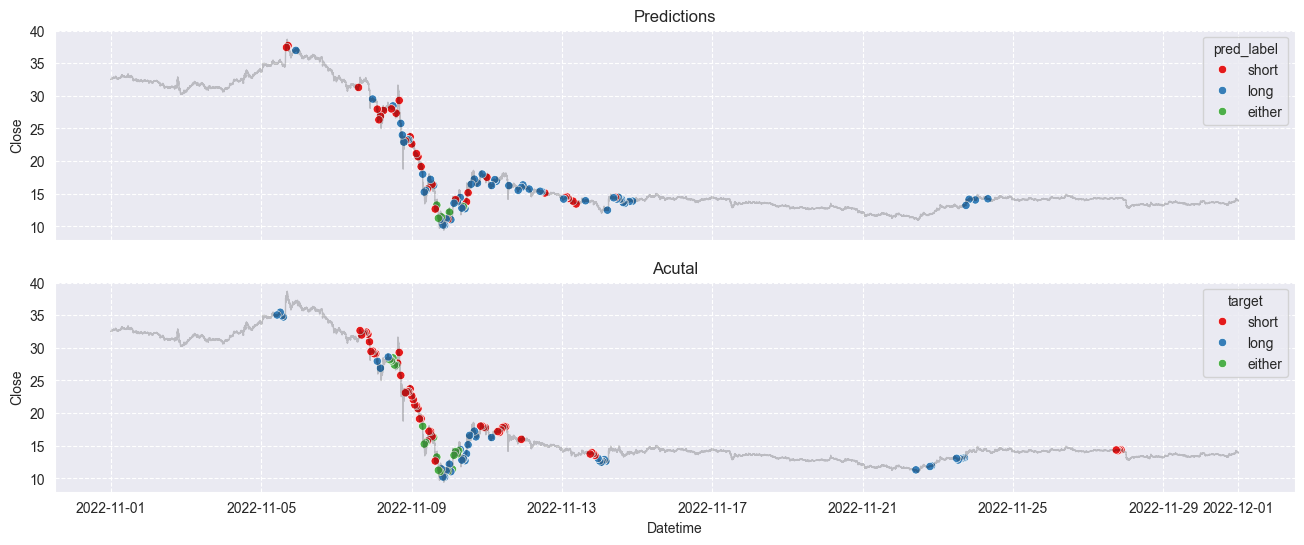

In [71]:
hue_order = ['short', 'long', 'either']

fig, ax = plt.subplots(2, 1, figsize = (16, 6), sharex = True, sharey=True)
cond1 = df['Datetime'] >= '11-01-2022'
cond2 = df['Datetime'] <= '12-01-2022'
sns.lineplot(df[cond1 & cond2], x = 'Datetime', y = 'Close', ax = ax[0], alpha = 0.2, lw = 1, color = 'black',)
sns.lineplot(df[cond1 & cond2], x = 'Datetime', y = 'Close', ax = ax[1], alpha = 0.2, lw = 1, color = 'black')

cond1 = pdf['Datetime'] >= '11-01-2022'
cond2 = pdf['Datetime'] <= '12-01-2022'
cond3 = pdf['pred_label'] != 'neither'
sns.scatterplot(pdf[cond1 & cond2 & cond3], x = 'Datetime', y = 'Close', hue = 'pred_label', palette = 'Set1', ax = ax[0], hue_order = hue_order)

cond3 = pdf['target'] != 'neither'
sns.scatterplot(pdf[cond1 & cond2 & cond3], x = 'Datetime', y = 'Close', hue = 'target', palette = 'Set1', ax = ax[1], hue_order = hue_order)

ax[0].set_title('Predictions')
ax[1].set_title('Acutal')
plt.show()

In [10]:
pdf[cond1 & cond2 & cond3].to_csv('../data/intermin/240m_15pct_6candles.csv', index = False)